In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [8]:
# Create custom ensemble for the estimator of Adaboost
class CustomEnsemble(BaseEstimator):
    def __init__(self, base_estimators):
        self.base_estimators = base_estimators

    def fit(self, X, y):
        for estimator in self.base_estimators:
            estimator.fit(X, y)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for estimator in self.base_estimators:
            predictions += estimator.predict(X)
        return predictions / len(self.base_estimators)

In [9]:
def boosting(file, train, test):
  print("TRAIN - TEST RATIO: ",train, test)
  # Load the data
  df = pd.read_csv(file, index_col='Date')
  df = df[['Price']]
  df = df.dropna() # Drop missing values
  df = df.reset_index(drop=True) # Reset the index
  # Split the data into training, testing, and validation sets
  train_size = int(train * len(df))
  test_size = int(test * len(df))
  train_data = df[:train_size]
  test_data = df[train_size:train_size+test_size]
  # Prepare data for training and testing
  x_train = np.array(train_data.index).reshape(-1, 1)
  y_train = np.array(train_data['Price'])
  x_test = np.array(test_data.index).reshape(-1, 1)
  y_test = np.array(test_data['Price'])
  linear_model = LinearRegression()
  # Fit linear model to predict residuals
  linear_model.fit(x_train, y_train)
  residuals = y_train - linear_model.predict(x_train)
  # plt.plot(residuals)
  # Initialize AdaBoostRegressor with custom ensemble
  # decision_tree_model = DecisionTreeRegressor(max_depth=1)
  svr_model = SVR(kernel='linear')
  # random_forest_model = RandomForestRegressor(n_estimators=10)
  model = AdaBoostRegressor(base_estimator=CustomEnsemble(base_estimators=[svr_model]),
                                    n_estimators=10, learning_rate=0.1)
  # Fit the model to residuals
  model.fit(x_train, residuals)
  # Prepare sub predictiosn
  linear_train_pred = linear_model.predict(x_train)
  linear_test_pred = linear_model.predict(x_test)
  ada_train_pred = model.predict(x_train)
  ada_test_pred = model.predict(x_test)
  # Make predictions
  train_predictions = linear_train_pred + ada_train_pred
  test_predictions = linear_test_pred + ada_test_pred
  # Evaluate the model
  train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
  test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
  print("Train RMSE:", train_rmse)
  print("Test RMSE:", test_rmse)

  # 6. Quá trình tạo index predict 30 ngày tiếp theo
  y_pred = model.predict(x_test) + linear_model.predict(x_test) # test predictions
  last_index = df.index[-1]
  # Create an array of 30 consecutive integers starting from the index after the last data point
  next_30_days_index = np.arange(last_index + 1, last_index + 91)
  # Reshape the index for prediction
  x_next_30_days = next_30_days_index.reshape(-1, 1)

  # Predict the closing prices for the next 30 days
  y_next_90_days =  linear_model.predict(x_next_30_days) + model.predict(x_next_30_days)

  # Print the predicted closing prices for the next 30 days
  print('Predicted closing prices for the next 90 days:')
  print(y_next_90_days)

  # Evaluate the predictions of the models
  # Linear Regression
  y_pred_model1 = linear_test_pred
  r2_model1 = r2_score(y_test, y_pred_model1)
  rmse_model1 = np.sqrt(mean_squared_error(y_test, y_pred_model1))
  mape_model1 = mean_absolute_percentage_error(y_test, y_pred_model1)
  mae_model1 = mean_absolute_error(y_test, y_pred_model1)
  print("Linear Regression:")
  print(f"- R^2 Score: {r2_model1:.3f}")
  print(f"- RMSE: {rmse_model1:.3f}")
  print(f"- MAPE: {mape_model1:.3f}")
  print(f"- MAE: {mae_model1:.3f}\n")
  # Support Vector Regression
  svr_model.fit(x_train, y_train)
  y_pred_model2 = svr_model.predict(x_test)
  r2_model2 = r2_score(y_test, y_pred_model2)
  rmse_model2 = np.sqrt(mean_squared_error(y_test, y_pred_model2))
  mape_model2 = mean_absolute_percentage_error(y_test, y_pred_model2)
  mae_model2 = mean_absolute_error(y_test, y_pred_model2)
  print("Support Vector Regression:")
  print(f"- R^2 Score: {r2_model2:.3f}")
  print(f"- RMSE: {rmse_model2:.3f}")
  print(f"- MAPE: {mape_model2:.3f}")
  print(f"- MAE: {mae_model2:.3f}\n")
  # Boosting Ensemble
  y_pred_stacking = test_predictions
  r2_stacking = r2_score(y_test, y_pred_stacking)
  rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
  mape_stacking = mean_absolute_percentage_error(y_test, y_pred_stacking)
  mae_stacking = mean_absolute_error(y_test, y_pred_stacking)

  print("Boosting Final:")
  print(f"- R^2 Score: {r2_stacking:.3f}")
  print(f"- RMSE: {rmse_stacking:.3f}")
  print(f"- MAPE: {mape_stacking:.3f}")
  print(f"- MAE: {mae_stacking:.3f}")

  # 9.Vẽ hình
  predict30days = y_next_90_days[:30]
  predict60days = y_next_90_days[29:61]
  predict90days = y_next_90_days[60:]

  prediect_30_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
  prediect_60_index = pd.RangeIndex(start=len(df)+28, stop=len(df)+60, step=1)
  prediect_90_index = pd.RangeIndex(start=len(df)+59, stop=len(df)+89, step=1)

  plt.plot(train_data.index, train_data['Price'])
  plt.plot(test_data.index, test_data['Price'])
  plt.plot(test_data.index, y_pred)
  plt.plot(prediect_30_index,predict30days)

  plt.plot(prediect_60_index,predict60days)

  plt.plot(prediect_90_index,predict90days)

  plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
  plt.show()

# FPT

TRAIN - TEST RATIO:  0.7 0.3


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 9150.065580278084
Test RMSE: 14578.469091080786
Predicted closing prices for the next 90 days:
[106373.65158103 106416.65543478 106459.65928854 106502.6631423
 106545.66699604 106588.6708498  106631.67470356 106674.67855732
 106717.68241107 106760.68626482 106803.69011858 106846.69397233
 106889.69782609 106932.70167984 106975.7055336  107018.70938735
 107061.7132411  107104.71709486 107147.72094862 107190.72480237
 107233.72865612 107276.73250988 107319.73636364 107362.7402174
 107405.74407114 107448.7479249  107491.75177865 107534.75563241
 107577.75948616 107620.76333993 107663.76719369 107706.77104742
 107749.77490119 107792.77875495 107835.78260869 107878.78646245
 107921.79031621 107964.79416997 108007.79802372 108050.80187747
 108093.80573123 108136.80958497 108179.81343874 108222.81729249
 108265.82114625 108308.82500001 108351.82885375 108394.83270751
 108437.83656127 108480.84041502 108523.84426878 108566.84812253
 108609.85197629 108652.85583005 108695.85968379 1

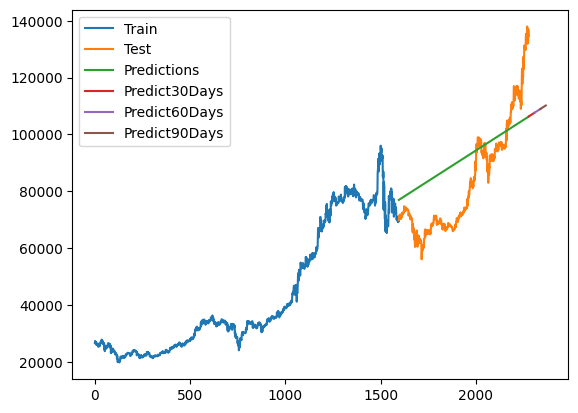

TRAIN - TEST RATIO:  0.8 0.2


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 9616.568501126754
Test RMSE: 14766.241749885132
Predicted closing prices for the next 90 days:
[95895.8547619  95932.53611111 95969.21746031 96005.89880953
 96042.58015873 96079.26150794 96115.94285714 96152.62420635
 96189.30555556 96225.98690477 96262.66825397 96299.34960318
 96336.03095239 96372.71230158 96409.39365079 96446.07500001
 96482.7563492  96519.43769842 96556.11904762 96592.80039682
 96629.48174603 96666.16309523 96702.84444445 96739.52579365
 96776.20714286 96812.88849206 96849.56984126 96886.25119048
 96922.93253968 96959.61388889 96996.29523809 97032.9765873
 97069.65793651 97106.33928572 97143.02063492 97179.70198412
 97216.38333334 97253.06468253 97289.74603175 97326.42738096
 97363.10873016 97399.79007936 97436.47142857 97473.15277778
 97509.83412698 97546.51547619 97583.1968254  97619.8781746
 97656.55952381 97693.24087302 97729.92222222 97766.60357143
 97803.28492064 97839.96626985 97876.64761905 97913.32896825
 97950.01031746 97986.69166667 98023.3730

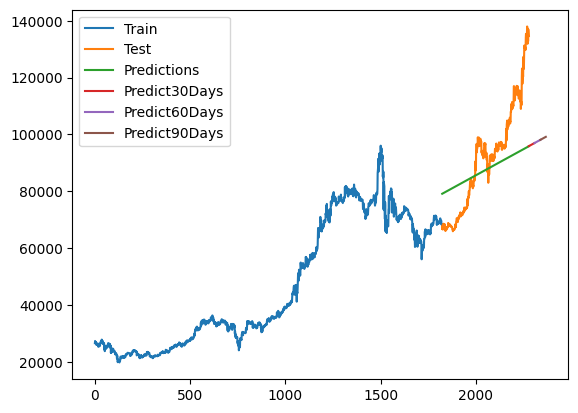

TRAIN - TEST RATIO:  0.9 0.1


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 9759.441545231963
Test RMSE: 20644.80628265895
Predicted closing prices for the next 90 days:
[92576.60044287 92611.80930025 92647.01815765 92682.22701506
 92717.43587245 92752.64472986 92787.85358725 92823.06244464
 92858.27130205 92893.48015942 92928.68901684 92963.89787423
 92999.10673162 93034.31558901 93069.5244464  93104.73330381
 93139.9421612  93175.15101861 93210.35987601 93245.5687334
 93280.77759079 93315.98644818 93351.19530558 93386.40416297
 93421.61302036 93456.82187776 93492.03073517 93527.23959256
 93562.44844997 93597.65730735 93632.86616475 93668.07502214
 93703.28387953 93738.49273695 93773.70159431 93808.91045173
 93844.11930911 93879.32816651 93914.53702392 93949.7458813
 93984.95473872 94020.16359612 94055.3724535  94090.5813109
 94125.79016829 94160.99902568 94196.20788306 94231.41674047
 94266.62559787 94301.83445527 94337.04331267 94372.25217007
 94407.46102746 94442.66988485 94477.87874224 94513.08759964
 94548.29645704 94583.50531442 94618.714171

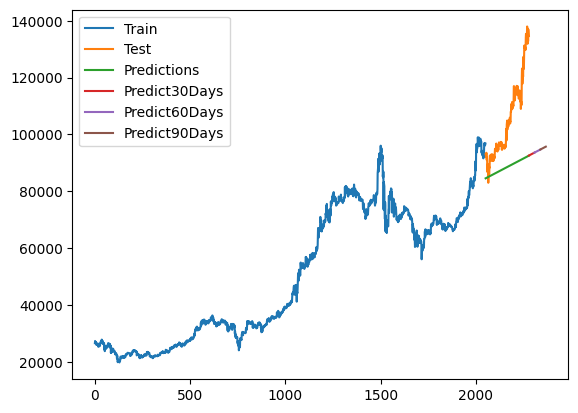

In [10]:
file = "fpt_data_final.csv"
boosting(file, 0.7, 0.3)
boosting(file, 0.8, 0.2)
boosting(file, 0.9, 0.1)

# ELC

TRAIN - TEST RATIO:  0.7 0.3


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 4774.955371162922
Test RMSE: 5143.103042744809
Predicted closing prices for the next 90 days:
[15909.56       15914.79410788 15920.02821576 15925.26232365
 15930.49643154 15935.73053942 15940.9646473  15946.19875519
 15951.43286307 15956.66697096 15961.90107884 15967.13518672
 15972.36929461 15977.6034025  15982.83751038 15988.07161826
 15993.30572614 15998.53983403 16003.77394191 16009.00804979
 16014.24215768 16019.47626556 16024.71037344 16029.94448133
 16035.1785892  16040.41269709 16045.64680498 16050.88091287
 16056.11502075 16061.34912863 16066.58323651 16071.81734439
 16077.05145228 16082.28556016 16087.51966805 16092.75377593
 16097.98788382 16103.2219917  16108.45609958 16113.69020746
 16118.92431535 16124.15842324 16129.39253112 16134.62663901
 16139.86074688 16145.09485477 16150.32896266 16155.56307054
 16160.79717842 16166.03128631 16171.26539419 16176.49950208
 16181.73360996 16186.96771784 16192.20182573 16197.43593362
 16202.6700415  16207.90414938 16213.138

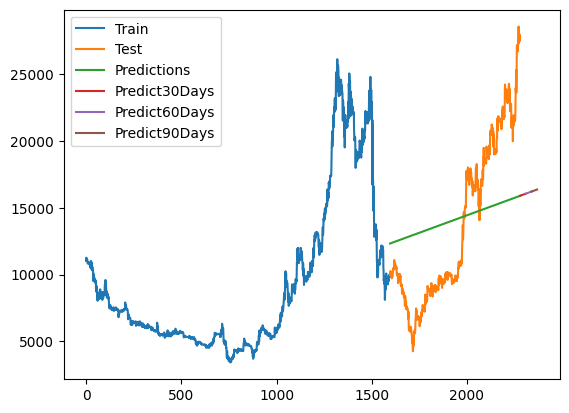

TRAIN - TEST RATIO:  0.8 0.2


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 5035.789146403959
Test RMSE: 7211.240123469388
Predicted closing prices for the next 90 days:
[12052.07021969 12055.14328722 12058.21635476 12061.2894223
 12064.36248983 12067.43555736 12070.5086249  12073.58169243
 12076.65475996 12079.7278275  12082.80089504 12085.87396257
 12088.94703011 12092.02009764 12095.09316517 12098.16623271
 12101.23930024 12104.31236778 12107.38543532 12110.45850285
 12113.53157038 12116.60463792 12119.67770545 12122.75077298
 12125.82384052 12128.89690806 12131.96997559 12135.04304313
 12138.11611066 12141.18917819 12144.26224573 12147.33531326
 12150.4083808  12153.48144834 12156.55451586 12159.6275834
 12162.70065093 12165.77371847 12168.846786   12171.91985354
 12174.99292108 12178.06598861 12181.13905614 12184.21212367
 12187.28519121 12190.35825875 12193.43132628 12196.50439382
 12199.57746135 12202.65052888 12205.72359642 12208.79666395
 12211.86973149 12214.94279903 12218.01586656 12221.08893409
 12224.16200163 12227.23506916 12230.30813

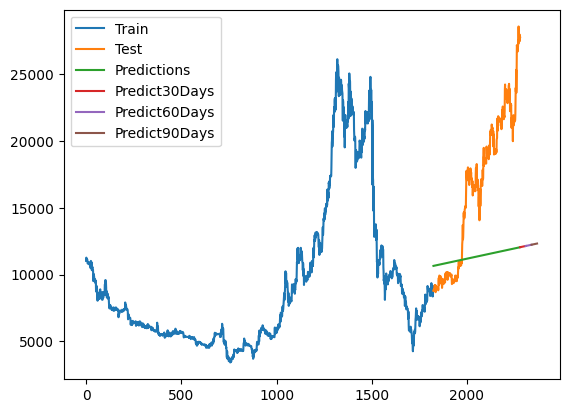

TRAIN - TEST RATIO:  0.9 0.1


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 4872.6058896853365
Test RMSE: 9831.031098774522
Predicted closing prices for the next 90 days:
[11871.43070866 11874.34118111 11877.25165357 11880.16212599
 11883.07259841 11885.98307087 11888.89354329 11891.80401572
 11894.71448817 11897.62496066 11900.53543308 11903.44590551
 11906.35637796 11909.26685039 11912.17732281 11915.08779527
 11917.99826775 11920.90874015 11923.8192126  11926.72968505
 11929.64015748 11932.55062991 11935.46110236 11938.37157478
 11941.28204724 11944.19251969 11947.10299215 11950.01346457
 11952.923937   11955.83440945 11958.74488188 11961.6553543
 11964.56582679 11967.47629924 11970.38677164 11973.29724409
 11976.20771655 11979.11818897 11982.0286614  11984.93913388
 11987.8496063  11990.76007873 11993.67055118 11996.58102364
 11999.49149606 12002.40196849 12005.31244094 12008.2229134
 12011.13338582 12014.04385828 12016.9543307  12019.86480313
 12022.77527558 12025.68574804 12028.59622049 12031.50669292
 12034.41716537 12037.3276378  12040.2381

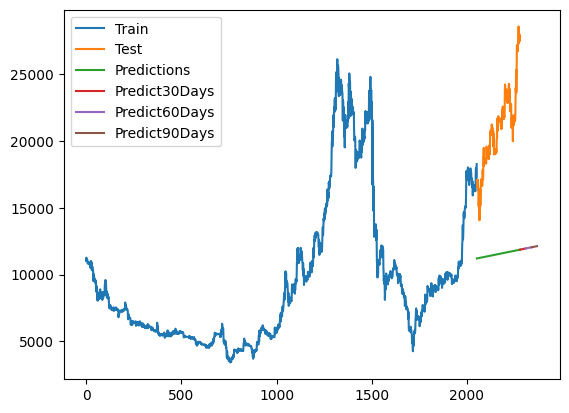

In [11]:
file = "elc_data_final.csv"
boosting(file, 0.7, 0.3)
boosting(file, 0.8, 0.2)
boosting(file, 0.9, 0.1)

# CMG

TRAIN - TEST RATIO:  0.7 0.3


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 5844.865890241793
Test RMSE: 11894.752536054175
Predicted closing prices for the next 90 days:
[54489.9180859  54507.94898268 54525.97987943 54544.01077618
 54562.04167296 54580.07256969 54598.10346647 54616.13436322
 54634.16525999 54652.19615674 54670.22705352 54688.25795027
 54706.28884702 54724.3197438  54742.35064053 54760.38153731
 54778.41243405 54796.44333083 54814.47422758 54832.50512433
 54850.53602111 54868.56691786 54886.59781461 54904.62871138
 54922.65960814 54940.69050489 54958.72140166 54976.75229842
 54994.78319517 55012.81409195 55030.84498869 55048.87588545
 55066.90678222 55084.93767895 55102.96857573 55120.9994725
 55139.03036926 55157.06126601 55175.09216276 55193.12305953
 55211.15395629 55229.18485304 55247.21574979 55265.24664657
 55283.27754332 55301.30844009 55319.33933685 55337.3702336
 55355.40113038 55373.43202712 55391.4629239  55409.49382064
 55427.52471742 55445.55561417 55463.58651093 55481.6174077
 55499.64830445 55517.67920121 55535.71009

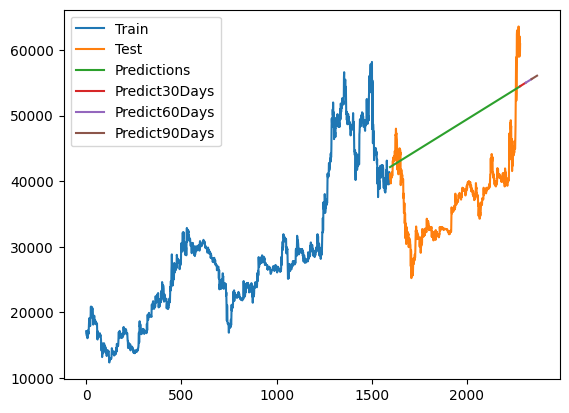

TRAIN - TEST RATIO:  0.8 0.2


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 6710.10381677764
Test RMSE: 8669.081715075094
Predicted closing prices for the next 90 days:
[49925.18106996 49940.83223594 49956.48340191 49972.13456792
 49987.7857339  50003.43689987 50019.08806585 50034.73923183
 50050.3903978  50066.04156378 50081.69272975 50097.34389573
 50112.99506171 50128.64622771 50144.29739369 50159.94855966
 50175.59972564 50191.25089165 50206.90205762 50222.5532236
 50238.20438958 50253.85555555 50269.50672153 50285.15788751
 50300.80905348 50316.46021946 50332.11138546 50347.76255144
 50363.41371742 50379.06488339 50394.7160494  50410.36721537
 50426.01838135 50441.66954733 50457.3207133  50472.97187928
 50488.62304526 50504.27421123 50519.92537721 50535.57654318
 50551.22770919 50566.87887517 50582.53004114 50598.18120715
 50613.83237313 50629.4835391  50645.13470508 50660.78587105
 50676.43703703 50692.08820301 50707.73936898 50723.39053496
 50739.04170094 50754.69286694 50770.34403292 50785.99519889
 50801.6463649  50817.29753088 50832.94869

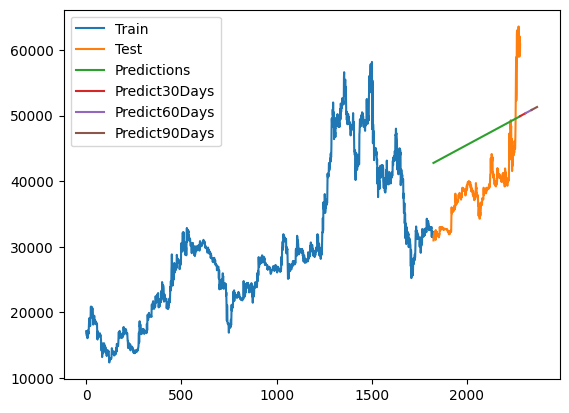

TRAIN - TEST RATIO:  0.9 0.1


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train RMSE: 7133.461455488486
Test RMSE: 6235.055208731554
Predicted closing prices for the next 90 days:
[42182.80591158 42194.01852955 42205.23114754 42216.44376551
 42227.65638349 42238.86900149 42250.08161947 42261.29423747
 42272.50685545 42283.71947343 42294.9320914  42306.14470938
 42317.35732738 42328.56994536 42339.78256335 42350.99518133
 42362.2077993  42373.42041728 42384.63303525 42395.84565325
 42407.05827124 42418.27088922 42429.48350721 42440.69612519
 42451.90874317 42463.12136114 42474.33397913 42485.54659711
 42496.7592151  42507.97183309 42519.18445109 42530.39706905
 42541.60968702 42552.82230502 42564.034923   42575.24754098
 42586.46015898 42597.67277696 42608.88539493 42620.09801292
 42631.31063089 42642.52324887 42653.73586687 42664.94848486
 42676.16110283 42687.37372081 42698.58633879 42709.79895676
 42721.01157476 42732.22419274 42743.43681073 42754.64942872
 42765.86204668 42777.07466468 42788.28728265 42799.49990064
 42810.71251862 42821.92513662 42833.137

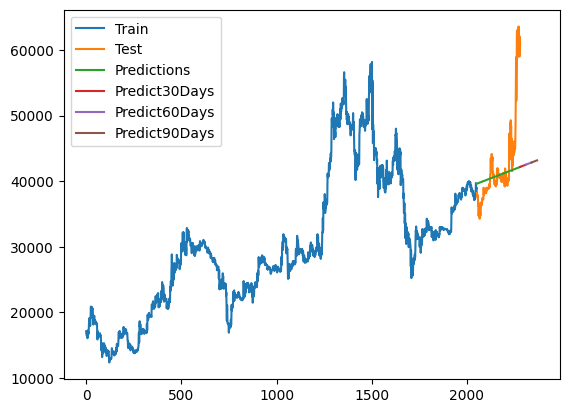

In [12]:
file = "cmg_data_final.csv"
boosting(file, 0.7, 0.3)
boosting(file, 0.8, 0.2)
boosting(file, 0.9, 0.1)